In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = tmp_val - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [2]:
# MNIST_Test Class

class MNIST_Test:
    
    # 생성자
    # xdata, tdata => numpy.array(...)
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # 은닉층 가중치  W2  Xavier/He 방법으로 self.W2 가중치 초기화
        self.W2 = np.random.randn(self.input_nodes, self.hidden_nodes) / np.sqrt(self.input_nodes/2)
        self.b2 = np.random.rand(self.hidden_nodes)      
        
        # 출력층 가중치는 W3  Xavier/He 방법으로 self.W3 가중치 초기화
        self.W3 = np.random.randn(self.hidden_nodes, self.output_nodes) / np.sqrt(self.hidden_nodes/2)
        self.b3 = np.random.rand(self.output_nodes)      
        
        # 2층 hidden layer unit 
        # 가중치 W, 바이어스 b 초기화
        #self.W2 = np.random.rand(input_nodes, hidden_nodes)  
        #self.b2 = np.random.rand(hidden_nodes)
        
        # 3층 output layer unit : 1 개 
        #self.W3 = np.random.rand(hidden_nodes,output_nodes)
        #self.b3 = np.random.rand(output_nodes)
                        
        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate
        
        print("MNIST_Test object is created !!!")
        
    # 손실함수
    def feed_forward(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z1 = np.dot(self.input_data, self.W2) + self.b2
        y1 = sigmoid(z1)
        
        z2 = np.dot(y1, self.W3) + self.b3
        y = sigmoid(z2)
    
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # obtain W and b
    def get_W_b(self):
        
        return self.W2,  self.b2, self.W3, self.b3
    
    # 손실 값 계산
    def loss_val(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z1 = np.dot(self.input_data, self.W2) + self.b2
        y1 = sigmoid(z1)
        
        z2 = np.dot(y1, self.W3) + self.b3
        y = sigmoid(z2)
    
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # query, 즉 미래 값 예측 함수
    def predict(self, input_data):    
        
        z2 = np.dot(input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
    
        # MNIST 경우는 one-hot encoding 을 적용하기 때문에
        # 0 또는 1 이 아닌 argmax() 를 통해 최대 인덱스를 넘겨주어야 함
        predicted_num = np.argmax(y)
    
        return predicted_num

    # 정확도 측정함수
    def accuracy(self, input_data, target_data):
        
        matched_list = []
        not_matched_list = []
        
        # list which contains (index, label, prediction) value
        index_label_prediction_list = []
        
        # temp list which contains label and prediction in sequence
        temp_list = []
        
        for index in range(len(input_data)):
                        
            label = int(target_data[index])
                        
            # normalize
            data = (input_data[index, :] / 255.0 * 0.99) + 0.01
      
            predicted_num = self.predict(data)
        
            if label == predicted_num:
                matched_list.append(index)
                
            else:
                not_matched_list.append(index)
                
                temp_list.append(index)
                temp_list.append(label)
                temp_list.append(predicted_num)
                
                index_label_prediction_list.append(temp_list)
                
                temp_list = []
                
        print("Current Accuracy = ", len(matched_list)/(len(input_data)) )
        
        return matched_list, not_matched_list, index_label_prediction_list
    
        
    # 수치미분을 이용하여 손실함수가 최소가 될때 까지 학습하는 함수
    def train(self, input_data, target_data):
        
        self.input_data = input_data
        self.target_data = target_data
        
        f = lambda x : self.feed_forward()
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
    
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
    
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)

In [3]:
# training data 
training_data = np.loadtxt('./mnist_train.csv', delimiter=',', dtype=np.float32)

print("training_data.shape = ", training_data.shape)

training_data.shape =  (60000, 785)


In [4]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 1  # hidden nodes 개수. Test
o_nodes = 10    # output nodes 개수
lr = 1e-2      # learning rate
epochs = 1   # 반복횟수

# 손실함수 값을 저장할 list 생성
loss_val_list = []

# MNIST_Test 객체 생성
obj = MNIST_Test(i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):    
                        
        # input_data, target_data normalize    
        input_data = ((training_data[index, 1:] / 255.0) * 0.99) + 0.01
        
        target_data = np.zeros(o_nodes) + 0.01    
        target_data[int(training_data[index, 0])] = 0.99
        
        obj.train(input_data, target_data)
                
        if (index % 200 == 0):
            print("epochs = ", step, ", index = ", index, ", loss value = ", obj.loss_val())
            
        # 손실함수 값 저장
        loss_val_list.append(obj.loss_val())        

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

MNIST_Test object is created !!!
Neural Network Learning using Numerical Derivative...
epochs =  0 , index =  0 , loss value =  8.277432579151078
epochs =  0 , index =  200 , loss value =  3.7226142724509304
epochs =  0 , index =  400 , loss value =  3.586845812234412
epochs =  0 , index =  600 , loss value =  3.5037850841631952
epochs =  0 , index =  800 , loss value =  3.447766115159326
epochs =  0 , index =  1000 , loss value =  3.43011180304587
epochs =  0 , index =  1200 , loss value =  3.2692739542690523
epochs =  0 , index =  1400 , loss value =  3.2676082273556415
epochs =  0 , index =  1600 , loss value =  3.4822569088097226
epochs =  0 , index =  1800 , loss value =  3.419474223284467
epochs =  0 , index =  2000 , loss value =  3.495055245835156
epochs =  0 , index =  2200 , loss value =  3.354130018726991
epochs =  0 , index =  2400 , loss value =  3.476805507668793
epochs =  0 , index =  2600 , loss value =  3.553179107013266
epochs =  0 , index =  2800 , loss value =  3.37

In [5]:
test_data = np.loadtxt('./mnist_test.csv', delimiter=',', dtype=np.float32)
print("test_data.shape = ", test_data.shape)

test_input_data = test_data[ :, 1: ]
test_target_data = test_data[ :, 0 ]

(true_list_1, false_list_1, index_label_prediction_list) = obj.accuracy(test_input_data, test_target_data) 

test_data.shape =  (10000, 785)
Current Accuracy =  0.2577


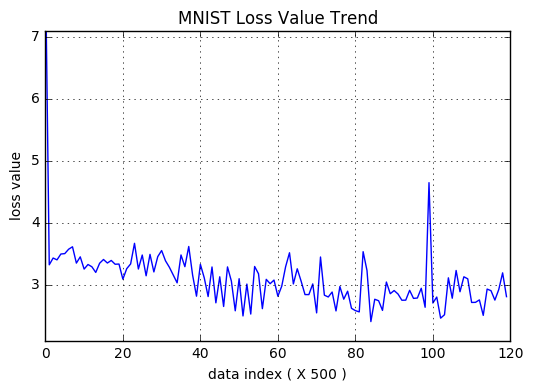

In [6]:
# 손실함수 추세 확인
Y_DATA_LIST = []

for index in range(0, len(loss_val_list), 500):
    Y_DATA_LIST.append(loss_val_list[index])
    
plt.title('MNIST Loss Value Trend')
plt.xlabel('data index ( X 500 )')
plt.ylabel('loss value')
plt.grid()
plt.ylim(2.1, 7.1)
plt.plot(Y_DATA_LIST, color='b')
plt.show()

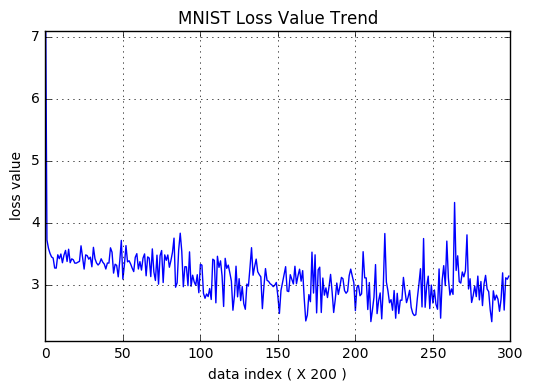

In [7]:
# 손실함수 추세 확인
Y_DATA_LIST = []

for index in range(0, len(loss_val_list), 200):
    Y_DATA_LIST.append(loss_val_list[index])
    
plt.title('MNIST Loss Value Trend')
plt.xlabel('data index ( X 200 )')
plt.ylabel('loss value')
plt.grid()
plt.ylim(2.1, 7.1)
plt.plot(Y_DATA_LIST, color='b')
plt.show()

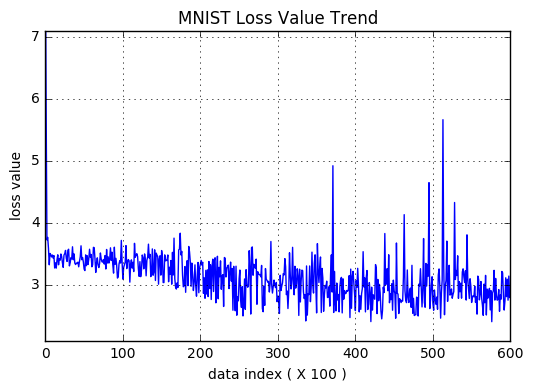

In [8]:
# 손실함수 추세 확인
Y_DATA_LIST = []

for index in range(0, len(loss_val_list), 100):
    Y_DATA_LIST.append(loss_val_list[index])
    
plt.title('MNIST Loss Value Trend')
plt.xlabel('data index ( X 100 )')
plt.ylabel('loss value')
plt.grid()
plt.ylim(2.1, 7.1)
plt.plot(Y_DATA_LIST, color='b')
plt.show()